## LLaMA2 chat with SQL

[LangChain Expression Langugae (LCEL)](https://python.langchain.com/docs/expression_language/) makes it easy to build diverse chains "from scratch."

This cookbook shows how to combine three ideas using LCEL:

* We want to enable a chat application
* We want to apply chat to a SQL database
* We want to use an open source LLM (LLaMA2)

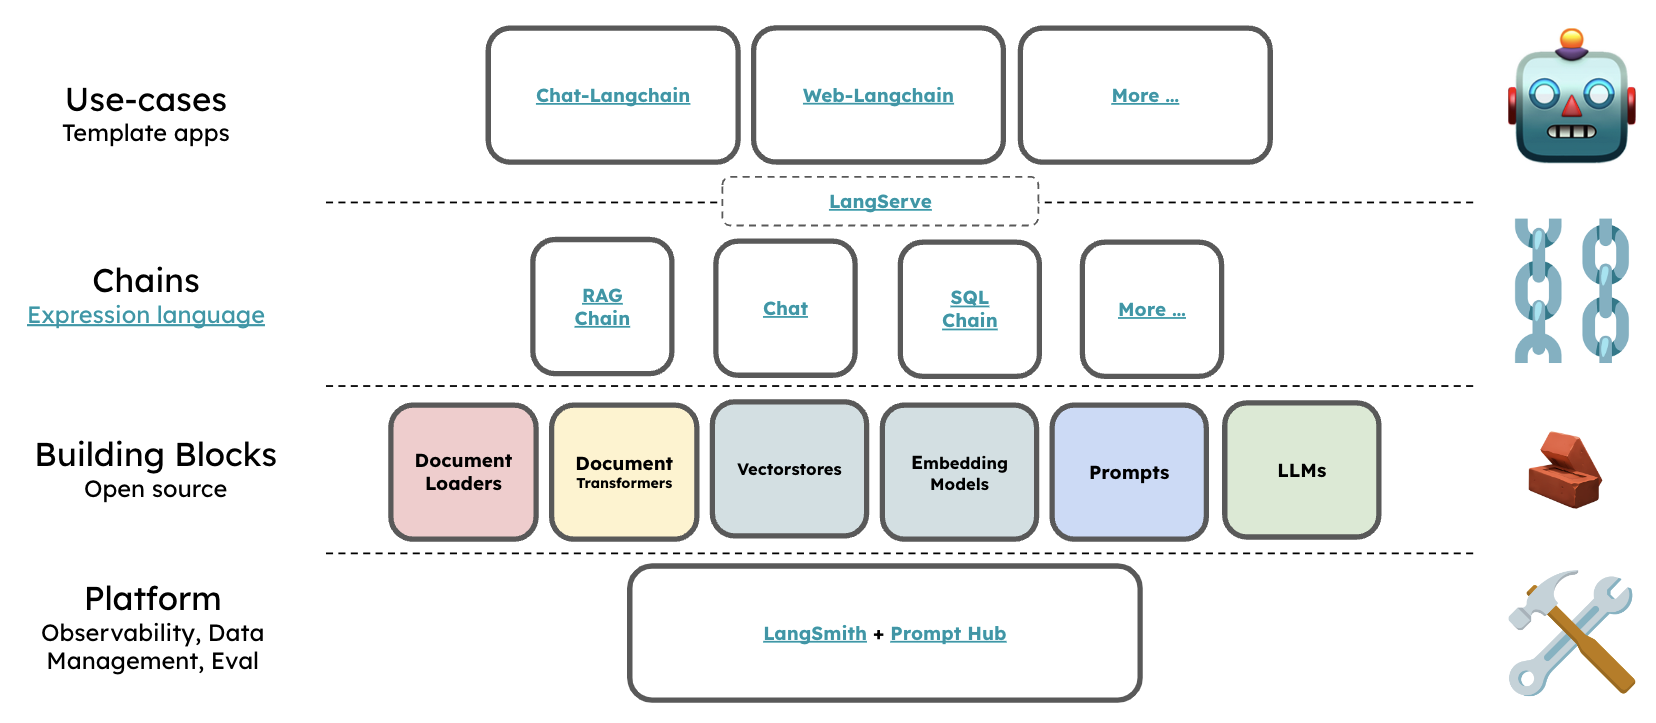

We can do this on SQLite DB containing 2023-24 NBA rosters.

## Packages

In [ ]:
! pip install langchain replicate

## LLM

Use Replicate API for `llama-2-13b-chat`.

Note: there is also support for running `LLaMA2` locally (see [here](https://python.langchain.com/docs/guides/local_llms)).

In [1]:
from getpass import getpass
from langchain.llms import Replicate
# REPLICATE_API_TOKEN = getpass()
# os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

# Replicate API
llama2_13b_chat = "meta/llama-2-13b-chat:f4e2de70d66816a838a89eeeb621910adffb0dd0baba3976c96980970978018d"
llm = Replicate(
    model=llama2_13b_chat,
    input={"temperature": 0.01, 
           "max_length": 500, 
           "top_p": 1}
)

Init param `input` is deprecated, please use `model_kwargs` instead.


## DB

Connect to a SQLite DB.

To create this particular DB, you can use the code and follow the steps shown [here](https://github.com/facebookresearch/llama-recipes/blob/main/demo_apps/StructuredLlama.ipynb).

In [2]:
from langchain.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///nba_roster.db", sample_rows_in_table_info= 0)

def get_schema(_):
    return db.get_table_info()

def run_query(query):
    return db.run(query)

## Query a SQL DB 

Follow the runnables workflow [here](https://python.langchain.com/docs/expression_language/cookbook/sql_db).

In [3]:
# Prompt
from langchain.prompts import ChatPromptTemplate
template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
SQL Query:"""
prompt = ChatPromptTemplate.from_messages([
    ("system", "Given an input question, convert it to a SQL query. No pre-amble."),
    ("human", template)
])

# Chain to query
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

sql_response = (
        RunnablePassthrough.assign(schema=get_schema)
        | prompt
        | llm.bind(stop=["\nSQLResult:"])
        | StrOutputParser()
    )

sql_response.invoke({"question": "What team is Klay Thompson on?"})

" SELECT * FROM nba_roster WHERE NAME = 'Klay Thompson';"

The [LangSmith trace](https://smith.langchain.com/public/afa56a06-b4e2-469a-a60f-c1746e75e42b/r) gives us visibility into the chain! 

In [68]:
# Chain to answer
template = """Based on the table schema below, question, sql query, and sql response, write a natural language response:
{schema}

Question: {question}
SQL Query: {query}
SQL Response: {response}"""
prompt_response = ChatPromptTemplate.from_messages([
    ("system", "Given an input question and SQL response, convert it to a natural langugae answer. No pre-amble."),
    ("human", template)
])

full_chain = (
    RunnablePassthrough.assign(query=sql_response) 
    | RunnablePassthrough.assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
    | prompt_response 
    | llm
)

full_chain.invoke({"question": "How many unique teams are there?"})

" Sure! Here's the natural language response based on the given SQL query and response:\n\nThere are 30 unique teams in the NBA roster."

Again, the [LangSmith trace](https://smith.langchain.com/public/10420721-746a-4806-8ecf-d6dc6399d739/r) gives us visibility into the chain.

## Chat with a SQL DB 

Next, we can add memory.

In [74]:
# Prompt
from langchain.prompts import ChatPromptTemplate
template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
SQL Query:"""
prompt = ChatPromptTemplate.from_messages([
    ("system", "Given an input question, convert it to a SQL query. No pre-amble."),
    MessagesPlaceholder(variable_name="history"),
    ("human", template)
])

memory = ConversationBufferMemory(return_messages=True)

# Chain to query with memory 
from langchain.memory import ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.schema.runnable import RunnableLambda, GetLocalVar, PutLocalVar

sql_chain = (
    RunnablePassthrough.assign(
       schema=get_schema,
       history=RunnableLambda(lambda x: memory.load_memory_variables(x)["history"])
    )| prompt
    | model.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)

def save(input_output):
    output = {"output": input_output.pop("output")}
    memory.save_context(input_output, output)
    return output['output']
    
sql_response_memory = RunnablePassthrough.assign(output=sql_chain) | save
sql_response_memory.invoke({"question": "What team is Klay Thompson on?"})

"SELECT Team \nFROM nba_roster \nWHERE NAME = 'Klay Thompson'"

In [75]:
sql_response_memory.invoke({"question": "What is his salary?"})

"SELECT SALARY \nFROM nba_roster \nWHERE NAME = 'Klay Thompson'"

In [76]:
# Chain to answer
template = """Based on the table schema below, question, sql query, and sql response, write a natural language response:
{schema}

Question: {question}
SQL Query: {query}
SQL Response: {response}"""
prompt_response = ChatPromptTemplate.from_messages([
    ("system", "Given an input question and SQL response, convert it to a natural langugae answer. No pre-amble."),
    ("human", template)
])

full_chain = (
    RunnablePassthrough.assign(query=sql_response_memory) 
    | RunnablePassthrough.assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
    | prompt_response 
    | llm
)

full_chain.invoke({"question": "What team is Klay Thompson on?"})

" Sure thing! Here's the natural language response based on the given SQL query and response:\n\nKlay Thompson plays for the Golden State Warriors."